In [6]:
# conda install geopandas
# conda install -c conda-forge geopy
# conda install -c anaconda requests
# conda install -c anaconda beautifulsoup4

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

#okresy = [
#    'okres-bratislava-i',
#    'okres-bratislava-ii',
#    'okres-bratislava-iii',
#    'okres-bratislava-iv',
#    'okres-bratislava-v']

okresy = [
    'bratislava-ii-podunajske-biskupice',
    'bratislava-ii-ruzinov',
    'bratislava-ii-stare-mesto',
    'bratislava-ii-vrakuna',
    'bratislava-iii-nove-mesto',
    'bratislava-iii-raca',
    'bratislava-iii-vajnory',
    'bratislava-iv-devin',
    'bratislava-iv-devinska-nova-ves',
    'bratislava-iv-dubravka',
    'bratislava-iv-karlova-ves',
    'bratislava-iv-lamac',
    'bratislava-iv-zahorska-bystrica',
    'bratislava-v-cunovo',
    'bratislava-v-jarovce',
    'bratislava-v-petrzalka',
    'bratislava-v-rusovce']

base_url = 'https://www.nehnutelnosti.sk/'
druh = '2-izbove-byty'  # 2-izbove-byty 3-izbove-byty
typ = 'predaj'  # predaj prenajom

out_path = f'{druh}_{typ}.csv'

In [2]:
# cf. https://realpython.com/beautiful-soup-web-scraper-python/#an-alternative-to-web-scraping-apis
geolocator = Nominatim(user_agent='mike')

title_list = []
address_list = []
district_list = []
district_id_list = []
lat_list = []
lon_list = []
area_list = []
price_list = []
price_per_m2_list = []
state_list = []
url_list = []
id_list = []

for okres in okresy:
    
    URL = f'https://www.nehnutelnosti.sk/{okres}/{druh}/{typ}/?p[page]='
    
    page_idx = 0

    max_num_retries = 3
    num_retries = 0

    while True:

        page_idx_url = f'{URL}{page_idx}'
        print(f'---\n{page_idx_url}\n---\n')

        page = requests.get(page_idx_url)
        soup = BeautifulSoup(page.content, "html.parser")

        results = soup.find_all(
            "div", {"class": "d-flex align-items-stretch flex-column align-self-stretch w-100 position-relative"})

        n_results = len(results)

        if n_results == 0:
            if num_retries <= max_num_retries:
                num_retries = num_retries + 1
                continue
            else:
                num_retries = 0
                break

        for idx in range(n_results):
            #print(results[idx].prettify())

            idx_soup = BeautifulSoup(results[idx].prettify(), "html.parser")

            title = idx_soup.find(
                "a", {"class": "advertisement-item--content__title d-block text-truncate"})
            title_str = title.get_text().strip()
            print(title_str)
            title_list.append(title_str)

            address_area = idx_soup.find_all(
                "div", {"class": "advertisement-item--content__info"})
            address_str = address_area[0].get_text().strip().split(',')[0].strip()
            print(address_str)
            address_list.append(address_str)
            district_str = address_area[0].get_text().strip().split(',')[1].strip()
            if district_str.startswith('okres'):
                district_str = address_str
            print(district_str)
            district_list.append(district_str)
            
            district_id = idx_soup.find(
                "a", {"class": "advertisement-item--content__additional-info--text"})
            district_id_str = district_id['href'].split('/')[3]
            print(district_id_str)
            district_id_list.append(district_id_str)

            location = geolocator.geocode(f'{address_str}, Bratislava')
            if location is None:
                latitude_float = -1.0
                longitude_float = -1.0
            else:
                latitude_float = location.latitude
                longitude_float = location.longitude
            print(latitude_float)
            print(longitude_float)
            #print(location.address)

            area = address_area[1].get_text().split('\n')
            if len(area) > 4:
                area_float = area[4].strip().replace(' m²', '').replace(',', '.')
                if not area_float.isnumeric():
                    area_float = -1.0
                else:
                    area_float = float(area_float)
            else:
                area_float = -1.0
            print(area_float)
            area_list.append(area_float)

            price = idx_soup.find(
                "div", {"class": "advertisement-item--content__price col-auto pl-0 pl-md-3 pr-0 text-right mt-2 mt-md-0 align-self-end"})
            price_float = price.get_text().split('\n')[1].replace('€','').strip().replace(' ','').replace(',', '.').replace('Cenadohodou', '-1')
            if not price_float.isnumeric():
                price_float = -1.0
            else:
                price_float = float(price_float)
                if (price_float) == 0.0:
                    price_float = -1.0
            print(price_float)
            price_list.append(price_float)

            if price_float == -1 or area_float == -1:
                price_m2_float = -1.0
            else:
                price_m2_float = price_float / area_float
            print(price_m2_float)
            price_per_m2_list.append(price_m2_float)

            url = idx_soup.find(
                "a", {"class": "advertisement-item--content__title d-block text-truncate"})
            url_str = url['href']
            print(url_str)
            url_list.append(url_str)
            
            id_str = url_str.split('/')[3]
            print(id_str)
            id_list.append(id_str)
            
            ad_page = requests.get(url_str)
            location = BeautifulSoup(ad_page.content, "html.parser").find(
                "div", {"id": "map-detail-popup"})
            
            if location is not None:
                latitude_float = location["data-map-lat"]
                longitude_float = location["data-map-long"]
                print(latitude_float)
                print(longitude_float)
            
            lat_list.append(latitude_float)
            lon_list.append(longitude_float)
            
            state = BeautifulSoup(ad_page.content, "html.parser").find(
                "li", {"class": "col-12 col-sm-6 col-md-4"})
            if state is not None:
                state_str = state.get_text().split('\n')[3].replace('Stav: ', '').lower().strip()
            else:
                state_str = '?'
            print(state_str)
            state_list.append(state_str)          
            
            print()

        page_idx = page_idx + 1
        num_retries = 0
    
df = pd.DataFrame(
    {'id': id_list,
     'title': title_list,
     'address': address_list,
     'district_id': district_id_list,
     'lat': lat_list,
     'lon': lon_list,
     'area': area_list,
     'price': price_list,
     'price_per_m2': price_per_m2_list,
     'state': state_list,
     'url': url_list})

df.to_csv(out_path, index=False)

#gdf = gpd.GeoDataFrame(
#    df, geometry=gpd.points_from_xy(df.lon, df.lat))

NameError: name 'Nominatim' is not defined

In [7]:
df = pd.read_csv(out_path)
df

,id,title,address,district_id,lat,lon,area,price,price_per_m2,state,url
0,4943047,"PREDAJ- priestranný 2 izb. byt v novostavbe, K...",Kazanská,bratislava-ii-podunajske-biskupice,48.131644,17.198740,-1.0,179900.0,-1.000000,novostavba,https://www.nehnutelnosti.sk/4943047/predaj-pr...
1,4899668,"2 izb. byt, Lotyšská ul. nie oproti Pentagonu ...",Lotyšská,bratislava-ii-podunajske-biskupice,48.138640,17.200189,49.0,127990.0,2612.040816,čiastočná rekonštrukcia,https://www.nehnutelnosti.sk/4899668/2-izb-byt...
2,4940292,Arvin & Benet | Veľkorysý 2i byt s balkónmi a ...,Podunajská,bratislava-ii-podunajske-biskupice,48.143166,17.198989,-1.0,179000.0,-1.000000,novostavba,https://www.nehnutelnosti.sk/4940292/arvin-ben...
3,4937854,Svetlý 2i byt s balkónom v novostavbe,Podunajská,bratislava-ii-podunajske-biskupice,48.143166,17.198989,48.0,149000.0,3104.166667,novostavba,https://www.nehnutelnosti.sk/4937854/svetly-2i...
4,4949043,Predám 2-izb. veľkometrážny byt,Bratislava II - Podunajské Biskupice,bratislava-ii-podunajske-biskupice,48.125107,17.210791,-1.0,188000.0,-1.000000,pôvodný stav,https://www.nehnutelnosti.sk/4949043/predam-2-...
...,...,...,...,...,...,...,...,...,...,...,...
1777,4839954,BYT - 2 izbový - 48 M2 - BRATISLAVA V. - Petrž...,Ulica Závodu Matador,bratislava-v-petrzalka,48.118102,17.094572,48.0,239900.0,4997.916667,novostavba,https://www.nehnutelnosti.sk/4839954/byt-2-izb...
1778,4888756,2 izbový kompletne zrekonštruovaný byt na Jung...,Jungmannova,bratislava-v-petrzalka,48.124990,17.114436,48.0,189900.0,3956.250000,kompletná rekonštrukcia,https://www.nehnutelnosti.sk/4888756/2-izbovy-...
1779,4894437,Veľký 2-izbový byt v Petržalke,Vyšehradská,bratislava-v-petrzalka,48.096757,17.103989,59.0,159900.0,2710.169492,pôvodný stav,https://www.nehnutelnosti.sk/4894437/velky-2-i...
1780,4884072,Topoľčianska - bývajte pri Draždiaku,Topoľčianska,developersky-projekt,48.108581,17.109468,-1.0,217224.0,-1.000000,vo výstavbe,https://www.nehnutelnosti.sk/4884072/topolcian...


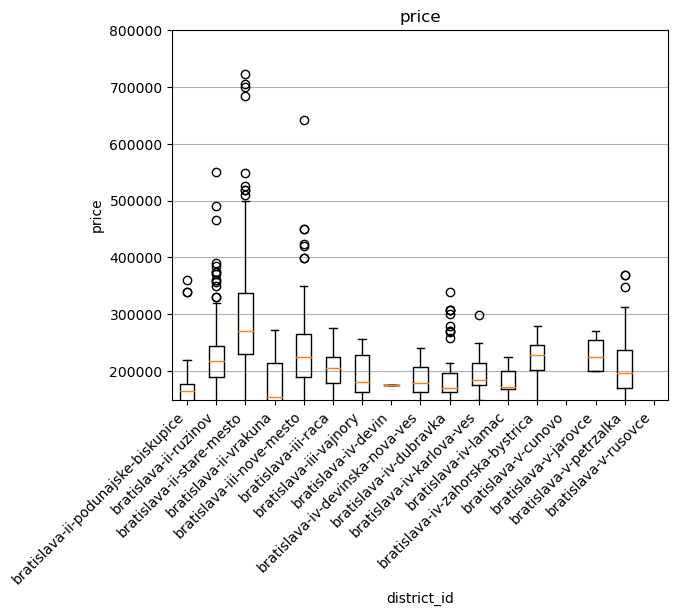

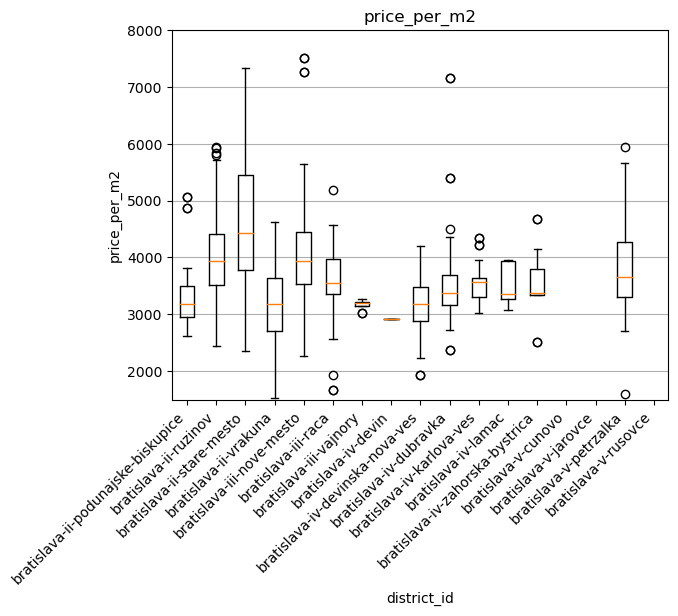

In [9]:
districts = okresy

col_names = ['price', 'price_per_m2']
ylims = [[150000, 800000], [1500, 8000]]

for y_lim_idx, col_name in enumerate(col_names):
    
    data = []
    for district in districts:

        # todo: omit -1s
        vals_array = df[df['district_id'] == district][[col_name]].values
        data.append(vals_array)
        
    # if using a Jupyter notebook, include:
    %matplotlib inline

    data_plot = [x.transpose()[0] for x in data]
    data_plot = [x[x != -1] for x in data_plot]
    #data_plot = [data_plot[0][data_plot[0] != -1]]
    
    fig, ax = plt.subplots()
    plt.xticks(rotation=45, ha='right')

    # build a box plot
    ax.boxplot(data_plot)

    # title and axis labels
    ax.set_title(col_name)
    ax.set_xlabel('district_id')
    ax.set_ylabel(col_name)
    xticklabels=districts
    ax.set_xticklabels(xticklabels)

    # add horizontal grid lines
    ax.yaxis.grid(True)

    plt.ylim(ylims[y_lim_idx])

    # show the plot
    plt.show()
